In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
import keras
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Input, Conv2D, MaxPooling2D, Flatten
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from sklearn.model_selection import train_test_split
from textblob import Word
from nltk import tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import gensim
import gensim.downloader as api

## Importing data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###### Microsoft dataset

In [ ]:
ms_train = pd.read_table("/content/drive/MyDrive/msr_paraphrase_train.txt", header=None, names=["is_p", "c2", "c3", "text1", "text2", "c6"])
ms_train = ms_train.drop(["c2", "c3", "c6"], axis = 1)
ms_train = ms_train.drop([0])
ms_train = ms_train[:2000]
ms_train = ms_train.reset_index()
ms_test = ms_train[["text1", "text2", "is_p"]]
ms_test = pd.read_table("/content/drive/MyDrive/msr_paraphrase_test.txt", header=None, names=["is_p", "c2", "c3", "text1", "text2", "c6"])
ms_test = ms_test.drop(["c2", "c3", "c6"], axis = 1)
ms_test = ms_test.drop([0])
ms_test = ms_test.reset_index()
ms_test = ms_test[["text1", "text2", "is_p"]]

###### Quora dataset

In [ ]:
data = pd.read_table("/content/drive/MyDrive/quora_duplicate_questions.tsv", header=0)
data = data.drop(["id", "qid1", "qid2"], axis = 1)
data = data.rename(columns={"question1": "text1", "question2": "text2", "is_duplicate": "is_p"})
data.dropna(inplace=True,axis=0)
data.drop_duplicates(inplace=True)
q_train, q_test = train_test_split(data, test_size=0.3)
q_train = q_train[:2000]

###### Twitter dataset

In [ ]:
twt_train = pd.read_table("/content/drive/MyDrive/train.data", header = None, names=["c1", "c2", "text1", "text2", "is_p", "c6", "c7"])
twt_train = twt_train.drop(["c1","c2", "c7", "c6"], axis = 1)
twt_test = pd.read_table("/content/drive/MyDrive/test.data", header = None, names=["c1", "c2", "text1", "text2", "is_p", "c6", "c7"])
twt_test["is_p"] = twt_test["is_p"].apply(lambda x: 0 if x <= 3 else 1)
twt_test = twt_test.drop(["c1","c2", "c7", "c6"], axis = 1)
twt_train["is_p"] = twt_train["is_p"].apply(lambda x: 1 if int(x[1]) + int(x[4]) == 5 and int(x[1]) >= 3 else 0)
twt_train.drop_duplicates(subset=['text1'], inplace = True)
twt_train = twt_train[:2000]

## Preprocessing

Concatinating the training datasets

In [ ]:
X = pd.concat([ms_train, q_train, twt_train])
X.reset_index(inplace=True)
X = X.drop(["index"], axis = 1)
X = X.drop(["level_0"], axis = 1)

In [ ]:
X2 = pd.concat([ms_train, q_train])
X2.reset_index(inplace=True)
X2 = X2.drop(["index"], axis = 1)
X2 = X2.drop(["level_0"], axis = 1)

Cleaning up the data by removing stop words and lemmatizing the remaining words

In [ ]:
def cleaning(df, stop_words):
    df['text1'] = df['text1'].apply(lambda x: ' '.join(str(x).lower() for x in str(x).split()))
    df['text1'] = df['text1'].str.replace('@"[^0-9a-zA-Z]+"', '')
    df['text1'] = df['text1'].apply(lambda x:' '.join(x for x in x.split() if x not in stop_words))
    df['text1'] = df['text1'].apply(lambda x:' '.join([Word(x).lemmatize() for x in x.split()]))
    df['text2'] = df['text2'].apply(lambda x: ' '.join(str(x).lower() for x in str(x).split()))
    df['text2'] = df['text2'].str.replace('@"[^0-9a-zA-Z]+"', '')
    df['text2'] = df['text2'].apply(lambda x:' '.join(x for x in x.split() if x not in stop_words))
    df['text2'] = df['text2'].apply(lambda x:' '.join([Word(x).lemmatize() for x in x.split()]))
    return df
stop_words = stopwords.words('english')
X = cleaning(X, stop_words)
X2 = cleaning(X2, stop_words)
ms_test = cleaning(ms_test, stop_words)
q_test = cleaning(q_test, stop_words)
twt_test = cleaning(twt_test, stop_words)

Tokenize

In [ ]:
X['text1'] = X['text1'].apply(lambda x: [word for word in word_tokenize(x) if word.isalpha()])
X['text2'] = X['text2'].apply(lambda x: [word for word in word_tokenize(x) if word.isalpha()])

In [ ]:
X2['text1'] = X2['text1'].apply(lambda x: [word for word in word_tokenize(x) if word.isalpha()])
X2['text2'] = X2['text2'].apply(lambda x: [word for word in word_tokenize(x) if word.isalpha()])

In [ ]:
ms_test['text1'] = ms_test['text1'].apply(lambda x: [word for word in word_tokenize(x) if word.isalpha()])
ms_test['text2'] = ms_test['text2'].apply(lambda x: [word for word in word_tokenize(x) if word.isalpha()])
q_test['text1'] = q_test['text1'].apply(lambda x: [word for word in word_tokenize(x) if word.isalpha()])
q_test['text2'] = q_test['text2'].apply(lambda x: [word for word in word_tokenize(x) if word.isalpha()])
twt_test['text1'] = twt_test['text1'].apply(lambda x: [word for word in word_tokenize(x) if word.isalpha()])
twt_test['text2'] = twt_test['text2'].apply(lambda x: [word for word in word_tokenize(x) if word.isalpha()])
ms_test.reset_index(inplace=True)
q_test.reset_index(inplace=True)
twt_test.reset_index(inplace=True)

In [ ]:
q_test = q_test[:1000]

In [ ]:
max = 256

## Wordnet

In [ ]:
def similarity_matrix(df):
  sim_matrix = np.zeros((len(df),max,max,1),)
  for i in range(len(df)):
    for j in range(len(df['text1'][i])):
      for k in range(len(df['text2'][i])):
          synset1 = wn.synsets(df["text1"][i][j])
          synset2 = wn.synsets(df["text2"][i][k])
          if len(synset1) > 0 and len(synset2) > 0:
            sim_matrix[i][j][k] = wn.wup_similarity(synset1[0], synset2[0]) * 100
          else:
            if df["text1"][i][j] == df["text2"][i][k]:
              sim_matrix[i][j][k] += 100
  return sim_matrix
X_train = similarity_matrix(X)

In [ ]:
ms_test1 = similarity_matrix(ms_test)
q_test1 = similarity_matrix(q_test)
twt_test1 = similarity_matrix(twt_test[:1000])

## GloVe

In [ ]:
glove_model = api.load("glove-twitter-25")

[==================================================] 100.0% 104.8/104.8MB downloaded


In [ ]:
def similarity_matrix(df):
  sim_matrix = np.zeros((len(df),max,max,1),)
  for i in range(len(df)):
    for j in range(len(df['text1'][i])):
      for k in range(len(df['text2'][i])):
        try:
          sim_matrix[i][j][k] = glove_model.similarity(df["text1"][i][j], df["text2"][i][k])*100
        except:
          if df["text1"][i][j] == df["text2"][i][k]:
            sim_matrix[i][j][k] = 100
          continue
  return sim_matrix
X_traing = similarity_matrix(X)
ms_testg = similarity_matrix(ms_test)
q_testg = similarity_matrix(q_test)
twt_testg = similarity_matrix(twt_test[:1000])

## Model Training

In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(256,256), return_sequences = True))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer=keras.optimizers.Adagrad(learning_rate=0.01), metrics = ['accuracy'])

In [ ]:
model4 = Sequential()
model4.add(LSTM(50, input_shape=(256,256), return_sequences = True))
model4.add(Dense(1,activation='sigmoid'))
model4.compile(loss = 'binary_crossentropy', optimizer=keras.optimizers.Adagrad(learning_rate=0.01), metrics = ['accuracy'])

In [ ]:
model2 = Sequential()
model2.add(Input(shape=(256,256,1)))
model2.add(Conv2D(64,kernel_size = (3,3), strides = 2, activation ='relu',padding ='same'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding="same"))
model2.add(Conv2D(128,kernel_size = (3,3), strides = 2, activation ='relu',padding ='same'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding="same"))
model2.add(Conv2D(256,kernel_size = (3,3), strides = 2, activation ='relu',padding ='same'))
model2.add(Flatten())
model2.add(Dense(256, activation ='relu'))
model2.add(Dense(64, activation ='relu'))
model2.add(Dense(16, activation ='relu'))
model2.add(Dense(1, activation = "sigmoid"))
model2.compile(loss = 'binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

In [ ]:
model3 = Sequential()
model3.add(Input(shape=(256,256,1)))
model3.add(Conv2D(64,kernel_size = (3,3), strides = 2, activation ='relu',padding ='same'))
model3.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding="same"))
model3.add(Conv2D(128,kernel_size = (3,3), strides = 2, activation ='relu',padding ='same'))
model3.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding="same"))
model3.add(Conv2D(256,kernel_size = (3,3), strides = 2, activation ='relu',padding ='same'))
model3.add(Flatten())
model3.add(Dense(256, activation ='relu'))
model3.add(Dense(64, activation ='relu'))
model3.add(Dense(16, activation ='relu'))
model3.add(Dense(1, activation = "sigmoid"))
model3.compile(loss = 'binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

In [ ]:
X['is_p'] = X['is_p'].apply(lambda x: int(x))
y_train = X['is_p']

In [ ]:
history1 = model.fit(X_train, y_train, epochs = 50, batch_size = 32)

In [ ]:
history2 = model2.fit(X_train, y_train, epochs = 35, batch_size=32)

In [ ]:
history3 = model3.fit(X_traing, y_train, epochs = 35, batch_size=32)

In [ ]:
history4 = model4.fit(X_traing, y_train, epochs = 50, batch_size=32)

## Plotting Graphs

In [ ]:
import matplotlib.pyplot as plt

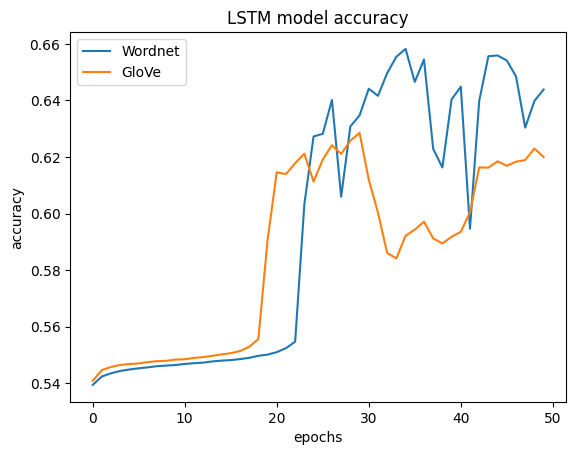

In [ ]:
plt.plot(history1.history['accuracy'])
plt.plot(history4.history['accuracy'])
plt.title('LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['Wordnet', 'GloVe'], loc='upper left')
plt.show()
plt.close()

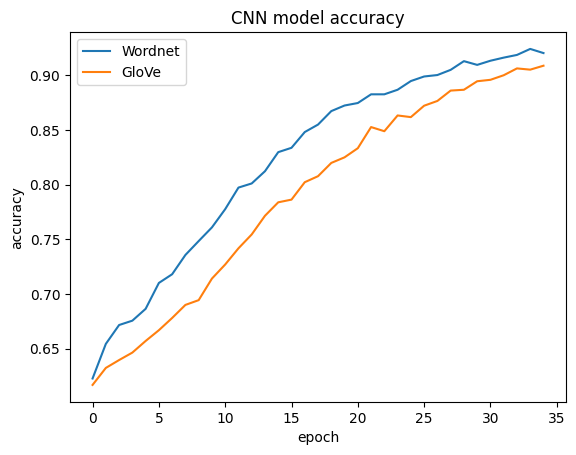

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history3.history['accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Wordnet', 'GloVe'], loc='upper left')
plt.show()
plt.close()

## Testing the model with each dataset separartely

In [ ]:
ms_test['is_p'] = ms_test['is_p'].apply(lambda x: int(x))
ms_y = ms_test['is_p']

In [ ]:
model.evaluate(ms_test1, ms_y)

In [ ]:
model4.evaluate(ms_testg, ms_y)

In [ ]:
model2.evaluate(ms_test1, ms_y)

In [ ]:
model3.evaluate(ms_testg, ms_y)

In [ ]:
q_test['is_p'] = q_test['is_p'].apply(lambda x: int(x))
q_y = q_test['is_p']

In [ ]:
model.evaluate(q_test1, q_y[:1000])

In [ ]:
model4.evaluate(q_testg, q_y[:1000])

In [ ]:
model2.evaluate(q_test1, q_y[:1000])

In [ ]:
model3.evaluate(q_testg, q_y[:1000])

In [ ]:
twt_test['is_p'] = twt_test['is_p'].apply(lambda x: int(x))
twt_y = twt_test['is_p']

In [ ]:
model.evaluate(twt_test1, twt_y[:1000])

In [ ]:
model4.evaluate(twt_testg, twt_y[:1000])

In [ ]:
model2.evaluate(twt_test1, twt_y[:1000])

In [ ]:
model3.evaluate(twt_testg, twt_y[:1000])